# Previsão de Série Temporal: Temperaturas Mínimas Diárias (Melbourne, 1981–1990)

**Dataset (Kaggle):** Daily minimum temperatures  
Link: https://www.kaggle.com/datasets/suprematism/daily-minimum-temperatures

**Objetivos:**
1. Carregar e explorar uma série temporal diária (Temperatura mínima em Melbourne).
2. Treinar um modelo clássico de previsão usando **sktime** (ThetaForecaster).
3. Treinar um modelo **LSTM** (Keras/TensorFlow) para previsão univariada.
4. Comparar os modelos por métricas (MAE e MASE), justificar a escolha e discutir resultados.

**Referências rápidas:**
- Kaggle dataset: acima (link).  
- Fallback do CSV igual ao do Kaggle (para conveniência):  
  `https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv`
- Métricas:  
  - MAE — documentação scikit-learn  
  - MASE — recomendada em Hyndman & Koehler (2006) para comparação entre séries



In [46]:
# Se estiver no Colab, instale as libs necessárias
!pip -q install --upgrade pip
!pip -q install sktime pandas numpy scikit-learn matplotlib seaborn tensorflow kaggle


In [47]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Reprodutibilidade
import random, tensorflow as tf
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Estética simples para plots
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

print("Versões:")
import sktime, sklearn
print("sktime:", sktime.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)


Versões:
sktime: 0.39.0
pandas: 2.2.2
numpy: 2.0.2
sklearn: 1.6.1
tensorflow: 2.19.0


In [48]:
# OPCIONAL: fazer download via Kaggle API (requer kaggle.json)
# Passos:
# 1) Obtenha seu token em: Kaggle > Account > Create New API Token
# 2) No Colab: execute esta célula, selecione o arquivo kaggle.json para upload

from pathlib import Path
from google.colab import files

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(parents=True, exist_ok=True)
kaggle_json = kaggle_dir / "kaggle.json"

if not kaggle_json.exists():
    print("Faça upload do seu kaggle.json (Kaggle API Token)...")
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        with open(kaggle_json, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(kaggle_json, 0o600)
        print("kaggle.json configurado.")
    else:
        print("Nenhum kaggle.json enviado. Você pode usar o fallback na próxima célula.")

# Tentar baixar via Kaggle se o token existir
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

if kaggle_json.exists():
    !kaggle datasets download -d suprematism/daily-minimum-temperatures -p data -o
    # Descompactar caso venha zipado
    for fname in os.listdir(data_dir):
        if fname.endswith(".zip"):
            zip_path = data_dir / fname
            !unzip -o "{zip_path}" -d data
else:
    print("Pulando download via Kaggle (sem token).")


Faça upload do seu kaggle.json (Kaggle API Token)...


Saving 1_Daily_minimum_temps.csv to 1_Daily_minimum_temps (1).csv
Nenhum kaggle.json enviado. Você pode usar o fallback na próxima célula.
Pulando download via Kaggle (sem token).


In [49]:
from pathlib import Path

csv_kaggle = Path("data/daily-minimum-temperatures.csv")
if csv_kaggle.exists():
    df = pd.read_csv(csv_kaggle)
    print("Carregado via Kaggle.")
else:
    # Fallback: mesmo CSV do dataset (repositório público)
    url_fallback = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    df = pd.read_csv(url_fallback)
    print("Carregado via fallback (mesmo CSV do Kaggle).")

df.head()


Carregado via fallback (mesmo CSV do Kaggle).


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [50]:
df.columns = [c.strip().capitalize() for c in df.columns]  # garantir "Date", "Temp"
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("Período:", df['Date'].min().date(), "→", df['Date'].max().date())
print("Registros:", len(df))
print(df.describe())

# Série como pandas Series com índice temporal
ts = df.set_index('Date')['Temp'].asfreq('D')
# Se houver dias faltantes, interpolar (não deve haver, mas por segurança)
if ts.isna().sum():
    ts = ts.interpolate()

ts.head()


Período: 1981-01-01 → 1990-12-31
Registros: 3650
                      Date         Temp
count                 3650  3650.000000
mean   1985-12-31 07:12:00    11.177753
min    1981-01-01 00:00:00     0.000000
25%    1983-07-02 06:00:00     8.300000
50%    1985-12-31 12:00:00    11.000000
75%    1988-06-30 18:00:00    14.000000
max    1990-12-31 00:00:00    26.300000
std                    NaN     4.071837


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


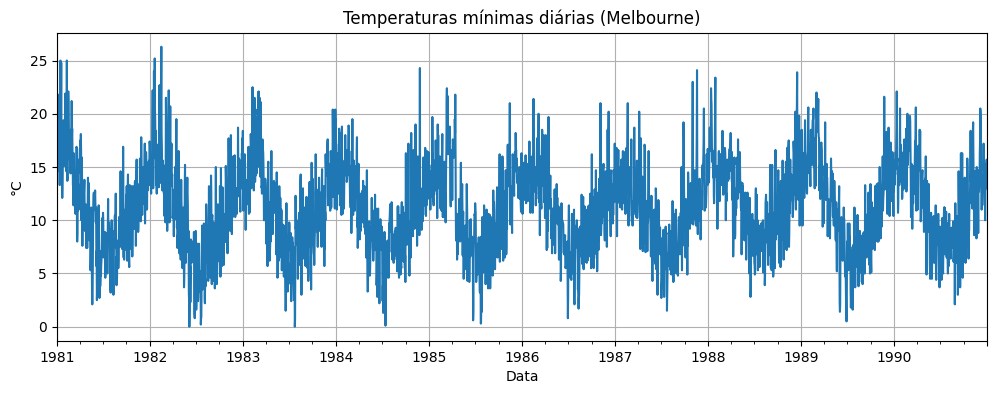

In [51]:
ax = ts.plot(title="Temperaturas mínimas diárias (Melbourne)")
ax.set_xlabel("Data")
ax.set_ylabel("°C")
plt.show()


In [52]:
# Usaremos o último ano (365 dias) para teste
TEST_HORIZON = 365
y_train = ts.iloc[:-TEST_HORIZON]
y_test  = ts.iloc[-TEST_HORIZON:]

print("Tamanho treino:", len(y_train), " | Tamanho teste:", len(y_test))
y_train.tail(), y_test.head()


Tamanho treino: 3287  | Tamanho teste: 365


(Date
 1989-12-27    13.3
 1989-12-28    11.7
 1989-12-29    10.4
 1989-12-30    14.4
 1989-12-31    12.7
 Freq: D, Name: Temp, dtype: float64,
 Date
 1990-01-01    14.8
 1990-01-02    13.3
 1990-01-03    15.6
 1990-01-04    14.5
 1990-01-05    14.3
 Freq: D, Name: Temp, dtype: float64)

In [53]:
def mase(y_true, y_pred, y_train, m=1):
    """
    Mean Absolute Scaled Error (MASE)
    Hyndman & Koehler (2006). m=1 = naive com lag 1.
    """
    mae_model = np.mean(np.abs(y_true - y_pred))
    # erro médio absoluto do naive (in-sample) com lag m
    naive_forecast = y_train.shift(m)
    mae_naive = np.mean(np.abs(y_train[m:] - naive_forecast[m:]))
    return mae_model / mae_naive

def evaluate_forecast(y_true, y_pred, y_train, m=1):
    mae = mean_absolute_error(y_true, y_pred)
    m_mase = mase(y_true, y_pred, y_train, m=m)
    return {"MAE": float(mae), "MASE": float(m_mase)}


In [54]:
ts.min(), (ts <= 0).sum()
# Deve mostrar o mínimo e quantos pontos são <= 0 (causadores do erro no modo multiplicativo)


(0.0, np.int64(2))

In [55]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.compose import TransformedTargetForecaster

# Horizonte de previsão alinhado ao conjunto de teste
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Pipeline: primeiro deseasonaliza (modelo "additive"), depois aplica Theta
pipe = TransformedTargetForecaster(steps=[
    ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
    ("forecaster", ThetaForecaster(sp=365, deseasonalize=False))  # já deseasonalizamos fora
])

pipe.fit(y_train)
y_pred_theta = pipe.predict(fh)
theta_metrics = evaluate_forecast(y_test, y_pred_theta, y_train, m=1)
theta_metrics


{'MAE': 3.15230241902882, 'MASE': 1.4703704503930135}

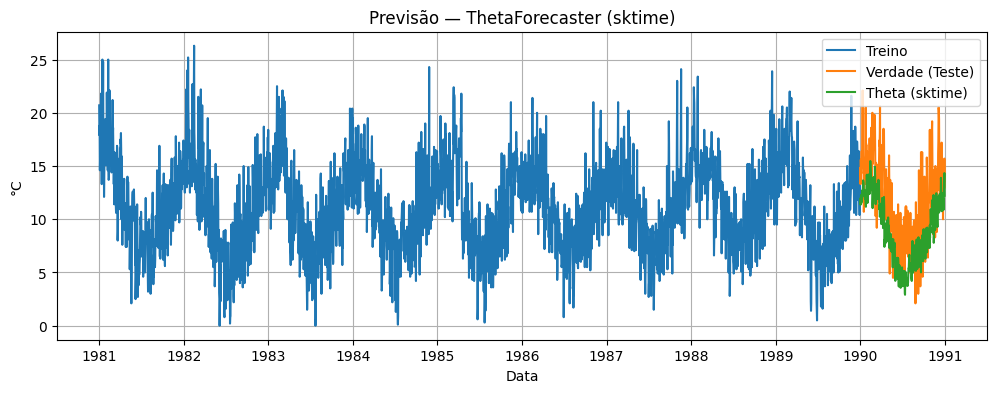

In [56]:
plt.plot(y_train.index, y_train.values, label="Treino")
plt.plot(y_test.index,  y_test.values,  label="Verdade (Teste)")
plt.plot(y_test.index,  y_pred_theta.values, label="Theta (sktime)")
plt.title("Previsão — ThetaForecaster (sktime)")
plt.xlabel("Data"); plt.ylabel("°C")
plt.legend()
plt.show()


In [57]:
# Normalizar com base apenas no treino
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1)).astype(np.float32)
y_test_scaled  = scaler.transform(y_test.values.reshape(-1,1)).astype(np.float32)

def make_windows(series_scaled, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(series_scaled) - window_size - horizon + 1):
        X.append(series_scaled[i:i+window_size])
        y.append(series_scaled[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

WINDOW = 30
HORIZON = 1

# Janelas apenas no treino para treinar; depois faremos rolling no teste
X_train, y_train_win = make_windows(y_train_scaled, window_size=WINDOW, horizon=HORIZON)

X_train.shape, y_train_win.shape


((3257, 30, 1), (3257, 1, 1))

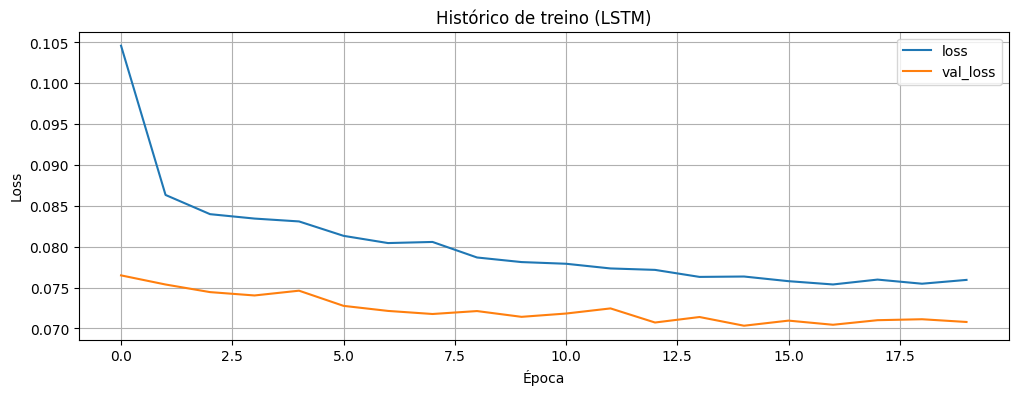

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1), return_sequences=False),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(HORIZON)  # saída 1 passo à frente
])

model.compile(optimizer="adam", loss="mae")
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_win,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=0
)

pd.DataFrame(history.history).plot(title="Histórico de treino (LSTM)")
plt.xlabel("Época"); plt.ylabel("Loss")
plt.show()


In [59]:
# Vamos gerar previsões 1-passo à frente ao longo de todo o teste
# mantendo uma janela deslizante que inclui treino + previsões anteriores.

series_all_scaled = np.concatenate([y_train_scaled, y_test_scaled], axis=0)
preds_scaled = []

# posição inicial para a janela que termina na última observação do treino
start = len(y_train_scaled) - WINDOW

window = series_all_scaled[start:start+WINDOW].copy()

for i in range(len(y_test_scaled)):
    x = window.reshape(1, WINDOW, 1)
    yhat_scaled = model.predict(x, verbose=0)
    preds_scaled.append(yhat_scaled.ravel()[0])
    # atualiza janela: remove o primeiro, adiciona o "alvo real" conhecido até aqui
    # (para simular 1-step ahead "com verdade", use o valor verdadeiro do teste)
    window = np.vstack([window[1:], y_test_scaled[i]])

preds_scaled = np.array(preds_scaled).reshape(-1,1)

# Desnormalizar para °C
y_pred_lstm = scaler.inverse_transform(preds_scaled).ravel()
y_true_test = y_test.values

lstm_metrics = evaluate_forecast(pd.Series(y_true_test, index=y_test.index),
                                 pd.Series(y_pred_lstm, index=y_test.index),
                                 y_train, m=1)

lstm_metrics


{'MAE': 1.7960715947085863, 'MASE': 0.8377656229009219}

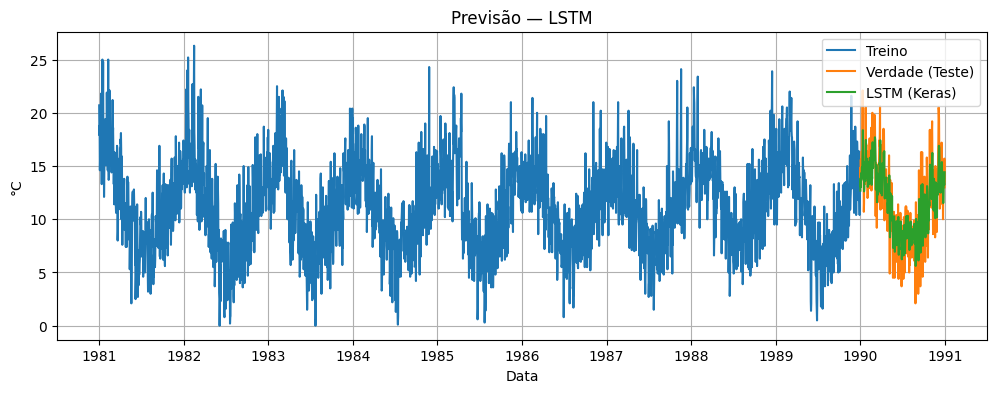

In [60]:
plt.plot(y_train.index, y_train.values, label="Treino")
plt.plot(y_test.index,  y_test.values,  label="Verdade (Teste)")
plt.plot(y_test.index,  y_pred_lstm,    label="LSTM (Keras)")
plt.title("Previsão — LSTM")
plt.xlabel("Data"); plt.ylabel("°C")
plt.legend()
plt.show()


In [61]:
comparison = pd.DataFrame({
    "Modelo": ["Theta (sktime)", "LSTM (Keras)"],
    "MAE":    [theta_metrics["MAE"], lstm_metrics["MAE"]],
    "MASE":   [theta_metrics["MASE"], lstm_metrics["MASE"]],
})
comparison.sort_values("MAE", inplace=True)
comparison.reset_index(drop=True, inplace=True)
comparison


,Modelo,MAE,MASE
0,LSTM (Keras),1.796072,0.837766
1,Theta (sktime),3.152302,1.470370


## Justificativa das Métricas

**MAE (Mean Absolute Error)**: é intuitiva e interpretável na **mesma unidade da série** (°C), informando o erro médio absoluto das previsões.  
Documentação: scikit-learn (`sklearn.metrics.mean_absolute_error`).  

**MASE (Mean Absolute Scaled Error)**: proposta por **Hyndman & Koehler (2006)**, o MASE escala o MAE do modelo pelo MAE de um **forecast ingênuo** (lag=1) no conjunto de treino.  
Vantagens: comparável entre séries e janelas, não sofre com problemas do MAPE quando há valores próximos de zero, e é recomendado para avaliar previsões univariadas de séries temporais.

**Interpretação**:  
- MAE mais baixo = melhor (erro médio menor em °C).  
- MASE < 1 indica que o modelo supera o ingênuo de lag 1; MASE ≈ 1 está no nível do ingênuo; MASE > 1 é pior que o ingênuo.

**Referências:**  
- scikit-learn — MAE.  
- Hyndman, R. J., & Koehler, A. B. (2006). *Another Look at Measures of Forecast Accuracy*, IJF.
